# Import Libraries

In [6]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd

import tqdm
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, losses
from tensorflow.keras.backend import ctc_batch_cost, ctc_decode
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split

In [7]:
print("TensorFlow Version:",tf.__version__)

TensorFlow Version: 2.16.1


# Load Data

In [8]:
root_dir = "../samples"

In [9]:
image_paths = []
labels = []

for file in tqdm.tqdm(os.listdir(root_dir)):
    filepath = os.path.join(root_dir, file)
    label = filepath.split("/")[-1].split(".")[0]

    image_paths.append(filepath)
    labels.append(label)

100%|██████████| 2600/2600 [00:00<00:00, 849115.50it/s]


In [10]:
images_df = pd.DataFrame({"image_path": image_paths, "label": labels})
images_df.head()

,image_path,label
0,../samples/259276.png,259276
1,../samples/312075.png,312075
2,../samples/989493.png,989493
3,../samples/405746.png,405746
4,../samples/231690.png,231690


In [11]:
characters = set(char for label in labels for char in label)
print("Characters:\n", characters)

Characters:
 {'5', '8', '7', '3', '9', '4', '0', '2', '6', '1'}


# Preprocess

In [ ]:
char_to_num = layers.StringLookup(
    vocabulary = list(characters),
    num_oov_indices = 0,
    mask_token = None
)

In [13]:
pd.DataFrame({"char": char_to_num.get_vocabulary(),
              "num": np.arange(1, len(char_to_num.get_vocabulary())+1)})

,char,num
0,5,1
1,8,2
2,7,3
3,3,4
4,9,5
5,4,6
6,0,7
7,2,8
8,6,9
9,1,10


In [14]:
num_to_char = layers.StringLookup(
    vocabulary = char_to_num.get_vocabulary(),
    mask_token = None,
    invert = True
)

In [15]:
def encode_single_sample(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    # image = tf.image.resize(image, [50, 200])
    image = tf.transpose(image, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return image, label

In [16]:
def process_dataset(X, y):
    images = []
    labels = []
    for img_path, label in zip(X, y):
        img, lbl = encode_single_sample(img_path, label)
        images.append(img.numpy())
        labels.append(lbl.numpy())
    return np.array(images), np.array(labels)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(np.array(image_paths), 
                                                    np.array(labels), 
                                                    test_size=0.10, random_state=42)

In [18]:
X_train_processed, y_train_processed = process_dataset(X_train, y_train)
X_test_processed, y_test_processed = process_dataset(X_test, y_test)

In [19]:
X_train_input = {"Input": X_train_processed, "Label": y_train_processed}
X_test_input = {"Input": X_test_processed, "Label": y_test_processed}

# Visualization

In [20]:
def visualize_df(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(10, 5))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['image_path']].values[0]
            label = df.loc[a][["label"]].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"CAPTCHA: {label}")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

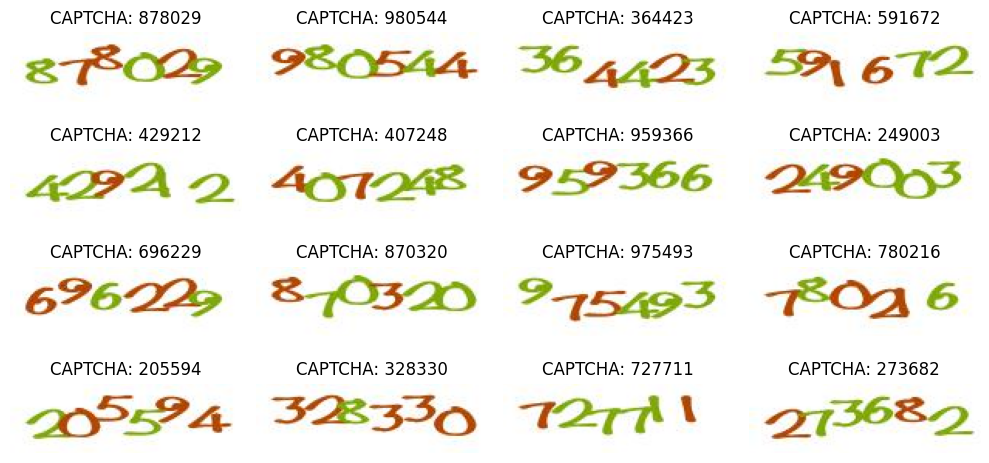

In [21]:
visualize_df(images_df)

# Model

In [22]:
class CTCLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_length = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_length, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_length, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred

In [23]:
input_layer = layers.Input(shape=(150, 45, 3), name="Input", dtype="float32")
label_layer = layers.Input(shape=(None,), name="Label", dtype="float32")

conv2_1 = layers.Conv2D(filters=32, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(input_layer)
max2_1 = layers.MaxPooling2D(strides=(2, 2))(conv2_1)

conv2_2 = layers.Conv2D(filters=64, kernel_size=(3, 3), activation="relu", kernel_initializer="he_normal", padding="same")(max2_1)
max2_2 = layers.MaxPooling2D(strides=(2, 2))(conv2_2)

reshape_layer = layers.Reshape(target_shape=((150 // 4), (45 // 4) * 64))(max2_2)
dense_1 = layers.Dense(units=32, activation="relu")(reshape_layer)
drop_1 = layers.Dropout((0.2))(dense_1)

bilstm_1 = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(drop_1)
bilstm_2 = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(bilstm_1)

output_layer = layers.Dense(len(characters) + 1, activation="softmax", name="Output")(bilstm_2)

output = CTCLayer(name="ctc_loss")(label_layer, output_layer)

model = models.Model(inputs=[input_layer, label_layer], outputs=output, name="OCR")

In [24]:
model.compile(optimizer=optimizers.Adam())

In [25]:
model.summary()

Model: "OCR"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Input (InputLayer)  │ (None, 150, 45,   │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 150, 45,   │        896 │ Input[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 75, 22,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 75, 22,    │     18,496 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 37, 11,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 37, 704)   │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 37, 32)    │     22,560 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 37, 32)    │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 37, 256)   │    164,864 │ dropout[0][0]     │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 37, 128)   │    164,352 │ bidirectional[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Label (InputLayer)  │ (None, None)      │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 37, 11)    │      1,419 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ctc_loss (CTCLayer) │ (None, 37, 11)    │          0 │ Label[0][0],      │
│                     │                   │            │ Output[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 372,587 (1.42 MB)

 Trainable params: 372,587 (1.42 MB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# plot_model(model, show_layer_names=True, show_shapes=True, expand_nested=True)

# Train

In [27]:
early_stopping = EarlyStopping(monitor="val_loss", patience=5)

In [28]:
# import numpy as np
# import tensorflow as tf
# from PIL import Image
# 
# from utils.CTCLayer import CTCLayer
# 
# # MODEL_PATH = "captcha_mpets.keras"
# MODEL_PATH = "captcha_mpets3.keras"
# model = tf.keras.models.load_model(MODEL_PATH, custom_objects={'CTCLayer': CTCLayer})

In [29]:
history = model.fit(
    X_train_input,
    y_train_processed,
    validation_data=(X_test_input, y_test_processed),
    epochs=50,
    batch_size=32,
    # callbacks=[early_stopping]
)
model.save("captcha_mpets3.keras")

Epoch 1/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 712.7441 - val_loss: 491.7970
Epoch 2/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 9s 126ms/step - loss: 498.4020 - val_loss: 489.8755
Epoch 3/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - loss: 497.3639 - val_loss: 489.0026
Epoch 4/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 496.5019 - val_loss: 489.7890
Epoch 5/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 495.7097 - val_loss: 488.4818
Epoch 6/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 131ms/step - loss: 495.3186 - val_loss: 480.5096
Epoch 7/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 478.7096 - val_loss: 398.3523
Epoch 8/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 133ms/step - loss: 383.9061 - val_loss: 204.1751
Epoch 9/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 10s 140ms/step - loss: 177.9813 - val_loss: 17.9860
Epoch 10/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - loss: 40.3943 - val_loss: 3.2129
Epoch 11/50
74/74 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - loss: 21.9816 - val_loss: 1.0693
Epoch

# Results

In [30]:
# from keras import models
# model = models.load_model("captcha_mpets.keras", custom_objects={"CTCLayer": CTCLayer})

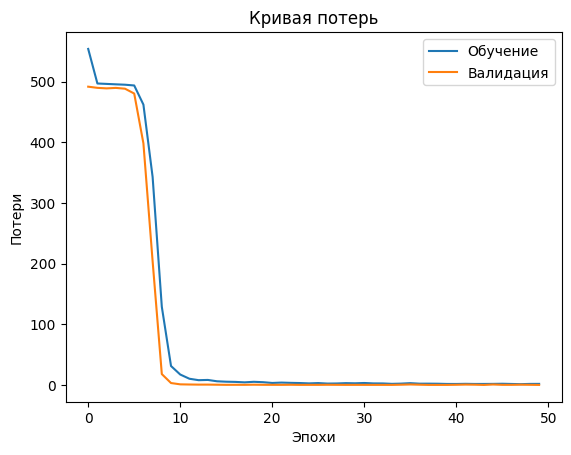

In [31]:
plt.figure()
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel("Эпохи")
plt.ylabel("Потери")
plt.legend(["Обучение", "Валидация"])
plt.title("Кривая потерь")
plt.show()
# Test

In [32]:
preds = model.predict(X_test_input)
input_length = np.ones(preds.shape[0]) * preds.shape[1]
print(input_length)
results = ctc_decode(preds, input_length=input_length, greedy=True)[0][0][:, :6]
pred_texts = []
for result in results:
    res = tf.strings.reduce_join(num_to_char(result+1)).numpy().decode("utf-8")
    pred_texts.append(res)


9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step


In [33]:
pred_df = pd.DataFrame({
    "Путь до файла": X_test,
    "Ожидалось": y_test,
    "Результат": pred_texts,
    "Совпадение": [1 if y_test[i] == pred_texts[i] else 0 for i in range(len(y_test))]
})

['../samples/651489.png' '../samples/253360.png' '../samples/905285.png'
 '../samples/227205.png' '../samples/124503.png' '../samples/789097.png'
 '../samples/954926.png' '../samples/258145.png' '../samples/517478.png'
 '../samples/471742.png' '../samples/141510.png' '../samples/407715.png'
 '../samples/175900.png' '../samples/178604.png' '../samples/113700.png'
 '../samples/668061.png' '../samples/929842.png' '../samples/479757.png'
 '../samples/479800.png' '../samples/185923.png' '../samples/517174.png'
 '../samples/697462.png' '../samples/507561.png' '../samples/276429.png'
 '../samples/997471.png' '../samples/898160.png' '../samples/772998.png'
 '../samples/902564.png' '../samples/941726.png' '../samples/382616.png'
 '../samples/740890.png' '../samples/285897.png' '../samples/860523.png'
 '../samples/475369.png' '../samples/994319.png' '../samples/817775.png'
 '../samples/237073.png' '../samples/254221.png' '../samples/678454.png'
 '../samples/382972.png' '../samples/396848.png' '.

In [34]:
pred_df.head(1000)

,Путь до файла,Ожидалось,Результат,Совпадение
0,../samples/651489.png,651489,651489,1
1,../samples/253360.png,253360,253360,1
2,../samples/905285.png,905285,905285,1
3,../samples/227205.png,227205,227205,1
4,../samples/124503.png,124503,124503,1
...,...,...,...,...
255,../samples/438412.png,438412,438412,1
256,../samples/657500.png,657500,657500,1
257,../samples/818246.png,818246,818246,1
258,../samples/624896.png,624896,624896,1


In [35]:
pred_df.to_excel("preds.xlsx")

In [40]:
def visualize_predictions(df: pd.DataFrame):
    fig, axes = plt.subplots(4, 4, figsize=(10, 5))

    for i, ax in enumerate(axes.ravel()):
        if i < len(df):
            a = np.random.randint(1, len(df), 1)[0]
            img_path = df.loc[a][['Путь до файла']].values[0]
            label = df.loc[a][["Ожидалось"]].values[0]
            pred = df.loc[a][["Результат"]].values[0]
            
            image = Image.open(img_path).convert('RGB')
            
            ax.imshow(image)
            ax.set_title(f"Ожидалось: {label}\nРезультат: {pred}")
            ax.axis('off')
            
        else:
            ax.axis('off')
            
    plt.tight_layout()
    plt.show()

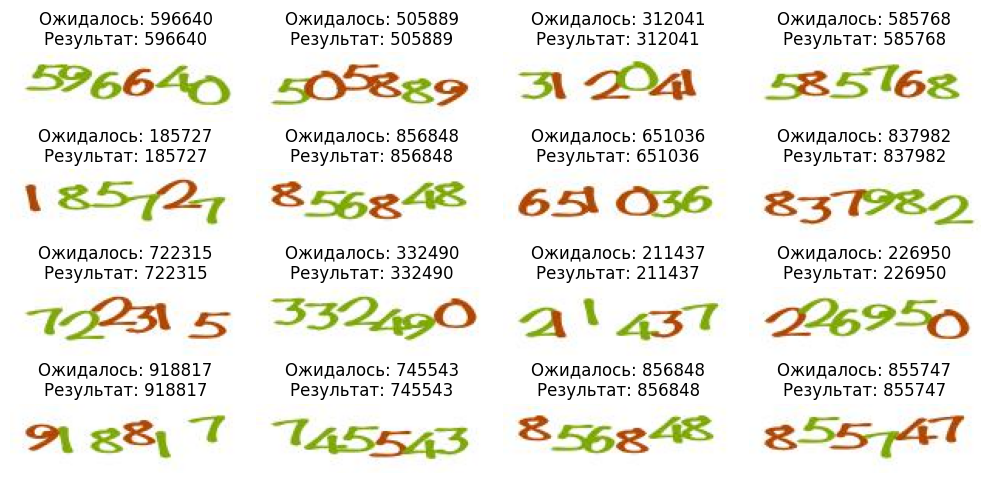

In [41]:
visualize_predictions(pred_df)